In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from functions.datacleaning import MoscowHousing as mh

In [2]:
# Get data
data = mh(
          coordinates=None,
          data_train="../prepared_data/train_prepared.csv",
          data_test="../prepared_data/test_prepared.csv",
          # test_prepared.csv is already complete
          need_correction=False,
          # Base float values are already normalized with 0 as mean
          normalize = False,
          # Passing floats (not really necessary)
          features_float = ["area_total", 
                            "distance", 
                            "area_kitchen", 
                            "area_living", 
                            "ceiling",
                            "distance_metro"]
        )

XTrain, YTrain = data.get_data_train()

In [78]:
# Features to remove in both training and test data
features_remove_train = ["id", "building_id", "layout", "area_total", "distance",
                         "seller", "condition", "stories", "windows_court", "windows_street",
                         "bathrooms_shared", "area_kitchen", "area_living", "district",
                         "loggias", "countpattern_street", "distance_metro", "rooms",
                         "material", "price_per_square_meter", "bathrooms_private",
                         "elevator_without", "balconies", "ceiling", "floor",
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones"]

"""features_remove_train = ["area_kitchen", "area_living", "layout",
                         "seller", "condition", "stories", "distance",
                         "windows_court", "windows_street", "distance_metro",
                         "bathrooms_shared", "bathrooms_private",
                         "balconies", "loggias", "countpattern_street",
                         "material", "ceiling", "area_total", "price_per_square_meter",
                         "elevator_without", "floor", "rooms", "district",
                         "elevator_passenger", "elevator_service", "parking", 
                         "garbage_chute", "heating", "latitude", "longitude", 
                         "street", "address", "phones"]"""

# First prep - remove unwanted features
X_Train = XTrain.drop(features_remove_train, axis=1)

In [57]:
print("number of nans in new", len(X_Train.loc[X_Train["new"].isnull()].index)) # 26
print("number of nans in constructed", len(X_Train.loc[X_Train["constructed"].isnull()].index))

number of nans in new 264
number of nans in constructed 794


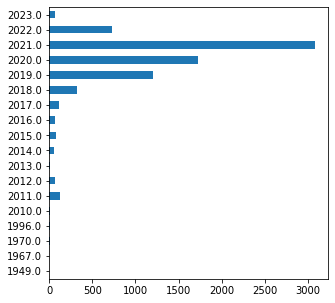

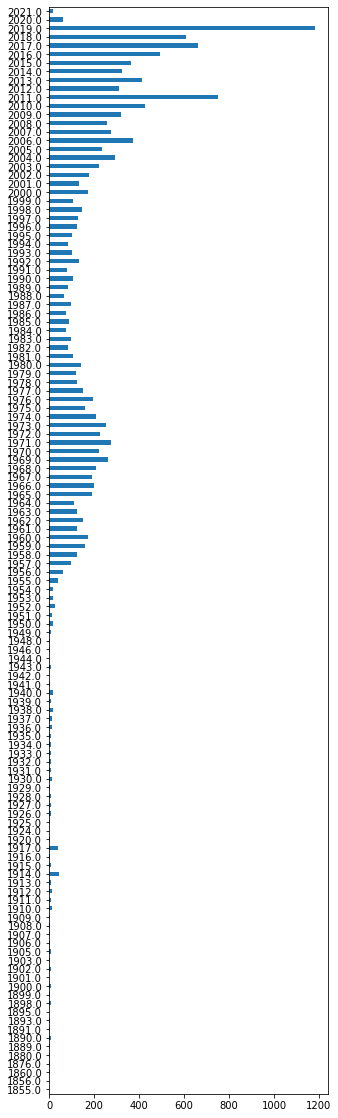

In [77]:
# 133/264 apts has constructed value when new is null
# (new can be set on 133 apts based on constructed)
nan = X_Train.loc[(X_Train["new"].isnull()) & (X_Train["constructed"].notnull())]
new = X_Train.loc[(X_Train["new"] == 1.0) & (X_Train["constructed"].notnull())] # 1949-2023
old = X_Train.loc[(X_Train["new"] == 0.0) & (X_Train["constructed"].notnull())] # 1855-2021

new["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,5))
plt.show()
plt.close()
old["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,20))
plt.show()

constructedValues = X_Train.loc[(X_Train["constructed"].notnull()) & (X_Train["new"].notnull())] # 
constructedNan = X_Train.loc[(X_Train["constructed"].isnull()) & (X_Train["new"].notnull())] # 663 new values that can be used to set constructed 

0
Test MSLE: 0.69


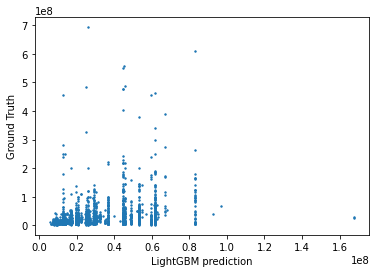

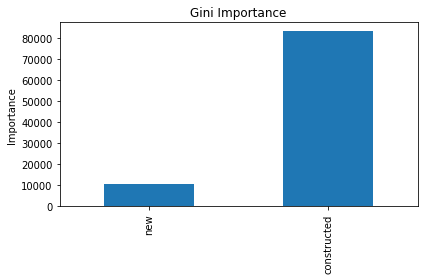

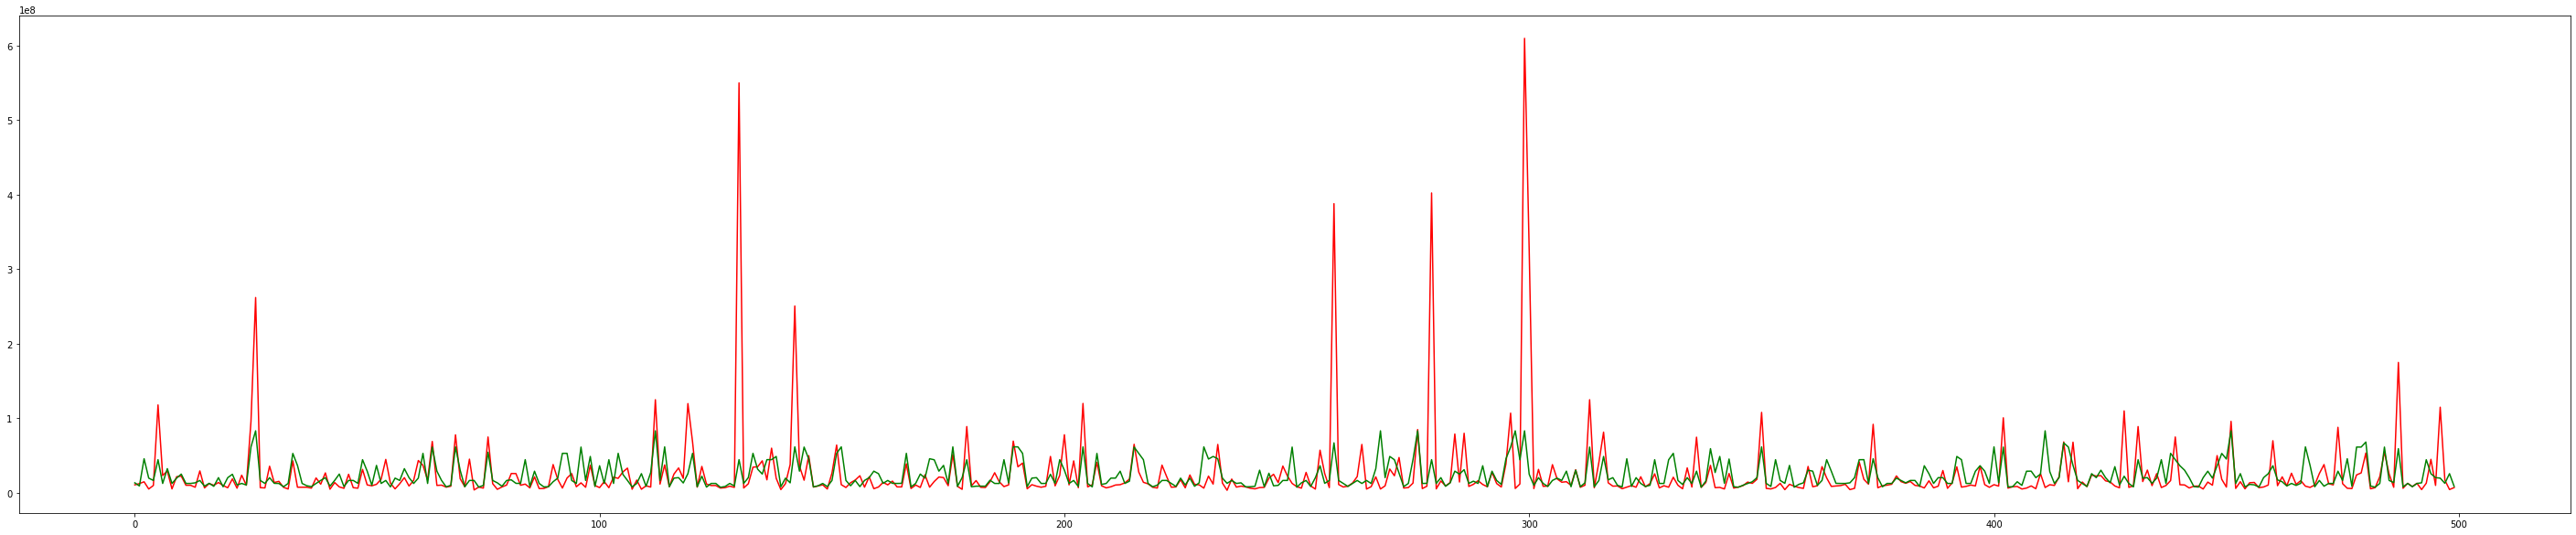

In [90]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error

def predict_and_analyze(dataset):
    # split training data into test and training split
    X_train1, X_test1 = train_test_split(dataset, test_size=0.15, random_state=42)

    # remove apartments with very high price from training-test data
    # qhigh = X_train1["price"].quantile(0.99)
    # X_train1 = X_train1[(X_train1["price"] < qhigh)]

    # get price columns 
    y_train = X_train1.pop("price")
    y_test = X_test1.pop("price")

    model5 = lgb.LGBMRegressor(
        num_leaves=100,
        max_depth=10, 
        random_state=42,
        metric='msle',
        n_jobs=4, 
        n_estimators=3000,
        colsample_bytree=0.95,
        subsample=0.9,
        learning_rate=0.05
    )

    model5.fit(X_train1, y_train)

    lgbm_prediction = model5.predict(X_test1)

    faulty_rows = []
    for i in range(len(lgbm_prediction)):
        if lgbm_prediction[i] < 900000:
            lgbm_prediction[i] = 900000
            faulty_rows.append(i)

    # list apartments resulting in too low price
    print(len(faulty_rows))

    lgb_msle = round(mean_squared_log_error(lgbm_prediction, y_test), 2)
    print('Test MSLE:', lgb_msle)

    # correct predictions are on the diagonal
    plt.scatter(lgbm_prediction, y_test, s=2)
    plt.xlabel('LightGBM prediction')
    plt.ylabel('Ground Truth')
    plt.show()

    # important features
    importances = model5.feature_importances_
    forest_importances = pd.Series(importances, index=X_train1.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Gini Importance")
    ax.set_ylabel("Importance")
    fig.tight_layout()

    # red is real prices, green is predicted prices
    plt.figure(figsize=(50, 10))
    plt.plot(y_test.values[:500], color = 'red')
    plt.plot(lgbm_prediction[:500], color = 'green')
    plt.show()
    

predict_and_analyze(X_Train)

Sets null values in constructed to random year in manual set range using new column.
Remove new column. 

Has almost no impact on simple model with a few selected features, but might make the data less noisy for more complex models.
When only using the constructed column vs only using constructed+new, it performs a little worse. From ~0.69 to 0.71 MSLE. 

0
Test MSLE: 0.71


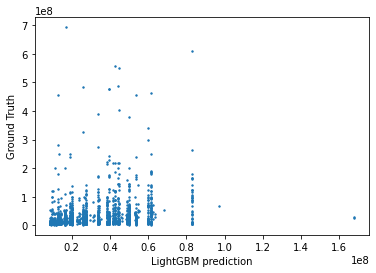

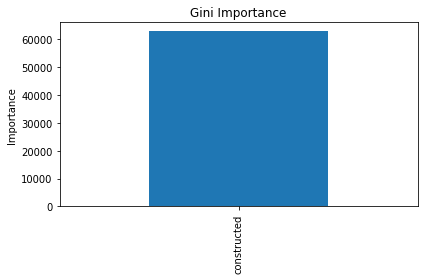

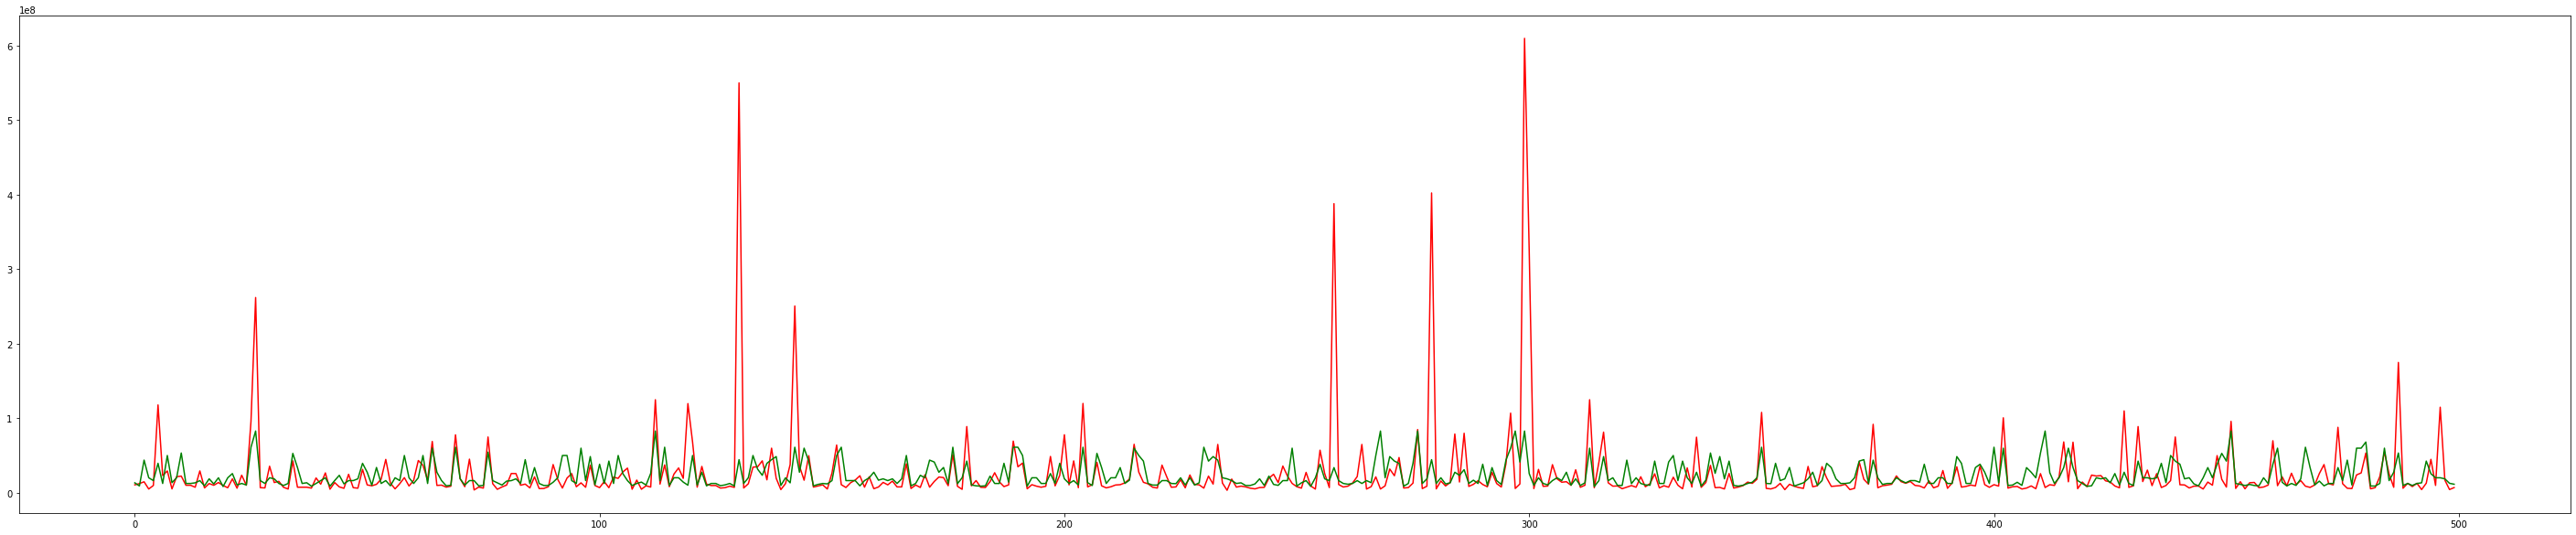

In [91]:
X_Train2 = X_Train.copy()

# set constructed on rows with new=True to random in range around manually picked year
is_new = (X_Train2["constructed"].isnull()) & (X_Train2["new"] == 1.0)
num_new = len(X_Train2.loc[is_new].index)
X_Train2["constructed"][is_new] = np.random.randint(2015, 2021, num_new)

# set constructed on rows with new=True to random in range around manually picked year
is_old = (X_Train2["constructed"].isnull()) & (X_Train2["new"] == 0.0)
num_old = len(X_Train2.loc[is_old].index)
X_Train2["constructed"][is_old] = np.random.randint(1955, 1985, num_old)

# replace null values with random in range around total mean value
mean_all = int(X_Train2["constructed"].mean())
num_null = len(X_Train2.loc[X_Train2["constructed"].isnull()].index)
X_Train2["constructed"][X_Train2["constructed"].isnull()] = np.random.randint(mean_all-5, mean_all+5, num_null)

X_Train2.pop("new")

# X_Train2["constructed"].value_counts().sort_index(ascending=True).plot(kind = 'barh', figsize=(5,20))
# plt.show()

predict_and_analyze(X_Train2)